# 0. Install and Import Dependencies

In [75]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

In [76]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [77]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [78]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [79]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [80]:
import gdown

In [81]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=fb3e58bc-5f50-4989-a7e2-876e5215d4d8
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 67.1MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [82]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [83]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [84]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [85]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [86]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [87]:
char_to_num(['a','r','u','n'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 18, 21, 14])>

In [88]:
num_to_char([1,  18,  21, 14])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'r', b'u', b'n'], dtype=object)>

In [89]:

def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    # Convert tokens to TensorFlow tensor
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [90]:
def load_data(path: tf.Tensor):
    # Decode the path from TensorFlow tensor to string
    path = path.numpy().decode('utf-8')
    # Extract the file name without the extension
    file_name = os.path.basename(path).split('.')[0]
    # Construct the video and alignment paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    # print(f'Video Path: {video_path}')
    # print(f'Alignment Path: {alignment_path}')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [91]:
test_path = './data/s1/bbaf2n.mpg'

In [92]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [93]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [94]:
frames.shape

TensorShape([75, 46, 140, 1])

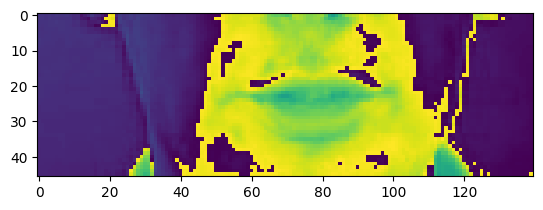

In [95]:
plt.imshow(frames[42])

In [96]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [97]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [98]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [99]:
from matplotlib import pyplot as plt

In [100]:
data = tf.data.Dataset.list_files('./data/s1/*mpg')
data

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [101]:
data = data.shuffle(500)
for element in data.take(5):
    print(element.numpy())

b'./data/s1/lwaz3a.mpg'
b'./data/s1/lgiz5a.mpg'
b'./data/s1/pgby7a.mpg'
b'./data/s1/lbwe6p.mpg'
b'./data/s1/prwx7s.mpg'


In [102]:
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # Added for split
train = data.take(450)
test = data.skip(450)

In [103]:
frames, alignments = data.as_numpy_iterator().next()

In [104]:
len(frames)

2

In [105]:
sample = data.as_numpy_iterator()

In [106]:
val = sample.next(); val[0]

array([[[[[ 1.4330341 ],
          [ 1.4330341 ],
          [ 1.4330341 ],
          ...,
          [ 0.19365324],
          [ 0.19365324],
          [ 0.19365324]],

         [[ 1.4330341 ],
          [ 1.4330341 ],
          [ 1.4330341 ],
          ...,
          [ 0.19365324],
          [ 0.19365324],
          [ 0.19365324]],

         [[ 1.3555727 ],
          [ 1.3555727 ],
          [ 1.3555727 ],
          ...,
          [ 0.19365324],
          [ 0.19365324],
          [ 0.19365324]],

         ...,

         [[ 0.92953557],
          [ 0.92953557],
          [ 0.92953557],
          ...,
          [ 9.643931  ],
          [ 9.682662  ],
          [ 9.798854  ]],

         [[ 0.92953557],
          [ 0.92953557],
          [ 0.92953557],
          ...,
          [ 9.372817  ],
          [ 9.489009  ],
          [ 9.682662  ]],

         [[ 0.92953557],
          [ 0.92953557],
          [ 0.92953557],
          ...,
          [ 9.52774   ],
          [ 9.52774   ],
          

In [107]:
image_array = val[0][0]

# Print the shape of the array to understand its dimensions
print(f"Original shape: {image_array.shape}")

Original shape: (75, 46, 140, 1)


In [108]:
# Ensure the array has the correct data type
if image_array.dtype != np.uint8:
    image_array = (255 * (image_array - np.min(image_array)) / np.ptp(image_array)).astype(np.uint8)

# Reshape the array to (num_frames, height, width, channels)
num_frames, height, width, channels = image_array.shape
print(num_frames,height, width, channels) #Checking if it still retauns the same shape

75 46 140 1


In [109]:
# Ensure the array has three channels (for RGB) or one channel (for grayscale)
if channels == 1:
    # Single-channel image, convert to three channels
    image_array = np.repeat(image_array, 3, axis=-1)

# Convert the array into a list of frames
frames = [image_array[i] for i in range(num_frames)]

# Save the image sequence as a GIF
imageio.mimsave('./animation.gif', frames, fps=10)

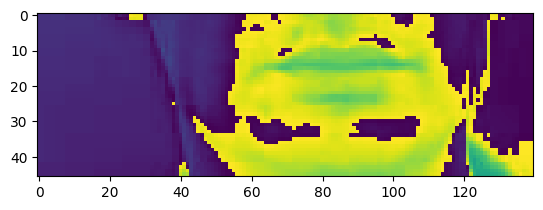

In [110]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][0])

In [111]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green with t two please'>

# 3. Design the Deep Neural Network

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [114]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [115]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [116]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [117]:
5*17*75

6375

In [118]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [119]:
yhat[0]

array([[0.02626603, 0.02588112, 0.02225067, ..., 0.02433925, 0.02145322,
        0.02347162],
       [0.02624901, 0.02550718, 0.02171901, ..., 0.02387028, 0.02097847,
        0.0231545 ],
       [0.02622178, 0.02559887, 0.02144335, ..., 0.02329855, 0.02059549,
        0.02281141],
       ...,
       [0.02412866, 0.02491462, 0.02253976, ..., 0.02556203, 0.02303035,
        0.02234409],
       [0.02366904, 0.02469362, 0.02312323, ..., 0.02576531, 0.02331316,
        0.02265547],
       [0.0232037 , 0.02486437, 0.02405955, ..., 0.02622204, 0.0236275 ,
        0.02307789]], dtype=float32)

In [120]:
yhat[0].shape

(75, 41)

In [121]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([23, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31])>

In [122]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'w22222222222222222222222222222222222222222222222222222222222222222222222222'>

In [123]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'w22222222222222222222222222222222222222222222222222222222222222222222222222'>

In [124]:
model.input_shape

(None, 75, 46, 140, 1)

In [125]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [126]:
from tensorflow.keras.optimizers import legacy

In [127]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [128]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [129]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [130]:
model.compile(optimizer=legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [131]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [132]:
schedule_callback = LearningRateScheduler(scheduler)

In [133]:
example_callback = ProduceExample(test)

In [134]:
# model.fit(train, validation_data= test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

The training process defined by the above model is expected to be time-intensive, potentially taking 10 hours or more with a normal Google Colab GPU. As the checkpoints for this model, I am skipping the training process. If you have a more extensive GPU, you can train it from scratch for potentially faster results.

# 5. Make a Prediction

In [135]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=d6e94c9d-1f6e-4dec-bbe7-c7e1bbc1c0f2
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 175MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [136]:
model.load_weights('models/checkpoint')

In [137]:
test_data = test.as_numpy_iterator()

In [138]:
sample = test_data.next()

In [139]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [140]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red in d nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green by u five again'>]

In [141]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [142]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red in d nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green by u five again'>]

# Test on a Video

In [143]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbaf2n.mpg'))

In [144]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [145]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 108ms/step


In [146]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [147]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]